In [ ]:
%%HTML
<!-- Mejorar visualización en proyector -->
<style>
.rendered_html {font-size: 1.2em; line-height: 150%;}
div.prompt {min-width: 0ex; padding: 0px;}
.container {width:95% !important;}
</style>

In [1]:
%autosave 0
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import torch

Autosave disabled


# DQN a partir de píxeles

A continuación entrenaremos una Deep Q network para jugar *Space invaders* a partir de imágenes

El ambiante de Open AI es

In [2]:
env_name = "SpaceInvadersNoFrameskip-v4"
#env_name = "PongNoFrameskip-v4"

(210, 160, 3)

<IPython.core.display.Javascript object>


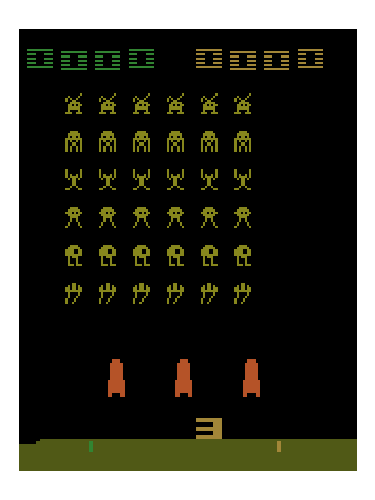

In [3]:
import gym

env = gym.make(env_name)
state = env.reset()

display(state.shape)

fig, ax = plt.subplots(figsize=(3, 4), tight_layout=True)
ax.axis('off')
ax.imshow(state);

El estado es una imagen de 210 x 160 x 3 pixeles

Haremos un preprocesamiento simple 
1. Descartar parte de la imagen que no aporta información
1. Reescalar la imagen 
1. Combinar los canales en una imagen de escala de grises
1. Crear un stack de cuatro frames como representación del estado
1. Convertir los pixeles a float y normalizar al rango [0, 1]


Para esto usaremos la librería *torchvision* y los wrappers de OpenAI

'Tamaño del tensor transformado:'

torch.Size([4, 84, 84])

<IPython.core.display.Javascript object>


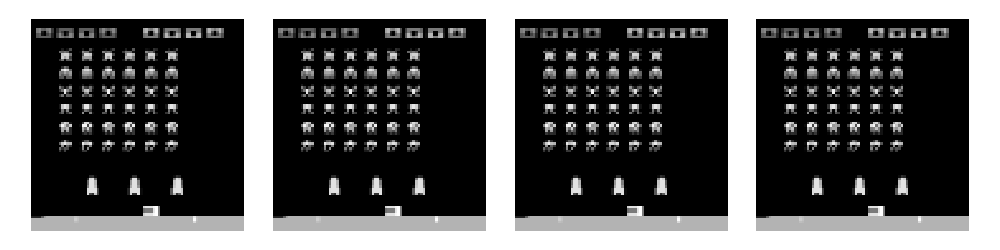

In [4]:
import gym
import torchvision
from atari_wrappers import NoopResetEnv, FireResetEnv, EpisodicLifeEnv, WarpFrame, ClipRewardEnv, FrameStack, MaxAndSkipEnv

def wrap_env(env, skip=4, k=4):
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=skip) # Descarta una cierta cantidad de cuadros, toma el máximo entre cuadros sucesivos y aplica la misma acción en todos los cuadros
    env = EpisodicLifeEnv(env) # Perder una vida es equivalente a perder el episodio
    env = FireResetEnv(env) # Hace un disparo al inicio (algunos juegos lo necesitan)
    env = WarpFrame(env) # Crop, resize y conversión a escala de  grises
    env = ClipRewardEnv(env) # La recompensa se corta en [-1, 1] (mejora la estabilidad)
    env = FrameStack(env, k=k) # El ambiente entrega de a 4 frames    
    return env


env = wrap_env(gym.make(env_name))
state = env.reset()

# Crear composición de transformaciones
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
# Función de para preprocesar
def preprocess(states):
    tmp = []
    for k in range(states.count()):
        tmp.append(transforms(states.frame(k)))
    return torch.cat(tmp) # Esto es un tensor de 4x84x84

transformed_state = preprocess(state)

display("Tamaño del tensor transformado:", transformed_state.shape)

fig, ax = plt.subplots(1, 4, figsize=(8, 2), tight_layout=True)
for k in range(4):
    ax[k].matshow(transformed_state[k, :, :].numpy(), cmap=plt.cm.Greys_r);
    ax[k].axis('off')

##### Frame skipping

Usaremos la técnica propuesta en (Minh et al 2013) conocida como *frame skipping*. Utilizamos 4 frames como estado pero ...

In [5]:
class ConvolutionalNeuralNetwork(torch.nn.Module):    
    def __init__(self, n_input, n_output, n_filters=32, n_hidden=256):
        super(type(self), self).__init__()
        self.conv1 = torch.nn.Conv2d(n_input, n_filters, kernel_size=8, stride=4)
        self.conv2 = torch.nn.Conv2d(n_filters, n_filters, kernel_size=4, stride=2)
        self.conv3 = torch.nn.Conv2d(n_filters, n_filters, kernel_size=3, stride=1)
        self.linear1 = torch.nn.Linear(7 * 7 * n_filters, n_hidden)
        self.output = torch.nn.Linear(n_hidden, n_output)
        self.activation = torch.nn.ReLU()
        
    def forward(self, x):
        h = self.activation(self.conv1(x))
        h = self.activation(self.conv2(h))
        h = self.activation(self.conv3(h))
        h = h.view(-1, 7*7*32)
        h = self.activation(self.linear1(h))
        return  self.output(h)

In [6]:
class ReplayMemory:
    
    def __init__(self, state_dim, memory_length=2000): 
        self.length = memory_length
        self.pointer = 0
        self.filled = False
        # Tensores vacíos para la historia
        self.s_current = torch.zeros((memory_length,) + state_dim)
        self.s_future = torch.zeros((memory_length,) + state_dim)
        self.a = torch.zeros(memory_length, 1, dtype=int)
        self.r = torch.zeros(memory_length, 1)
        # Adicionalmente guardaremos la condición de término
        self.end = torch.zeros(memory_length, 1, dtype=bool)
    
    def push(self, s_current, s_future, a, r, end):
        # Agregamos una tupla en la memoria
        self.s_current[self.pointer] = s_current
        self.s_future[self.pointer] = s_future
        self.a[self.pointer] = a
        self.r[self.pointer] = r 
        self.end[self.pointer] = end
        if self.pointer + 1 == self.length:
            self.filled = True
        self.pointer =  (self.pointer + 1) % self.length
        
    def sample(self, size=64):        
        # Extraemos una muestra aleatoria de la memoria
        if self.filled:
            idx = np.random.choice(self.length, size)
        elif self.pointer > size:
            idx = np.random.choice(self.pointer, size)
        else:
            return None        
        return self.s_current[idx], self.s_future[idx], self.a[idx], self.r[idx], self.end[idx]    
    

In [25]:
import copy
    
class DeepQNetwork:
    def __init__(self, q_model, gamma=0.99, double_dqn=False, learning_rate=1e-3, 
                 target_update_freq=500, clip_grads=True, clip_error=True, huber=False):
        self.double_dqn = double_dqn
        self.gamma = gamma
        self.q_policy = q_model
        self.n_output = q_model.output.out_features
        self.clip_error = clip_error
        self.clip_grads = clip_grads
        self.update_counter = 0
        self.target_update_freq = target_update_freq
        if not huber:
            self.criterion = torch.nn.MSELoss()
        else:
            self.criterion = torch.nn.SmoothL1Loss()
        self.optimizer = torch.optim.RMSprop(self.q_policy.parameters(), lr=learning_rate)
        
        if double_dqn:
            self.q_target = copy.deepcopy(self.q_policy)
            self.q_target.eval()
    
    def select_action(self, state, epsilon=0.):
        # Estrategia epsilon greedy para seleccionar acción
        if torch.rand(1).item() < 1. - epsilon: 
            self.q_policy.eval()
            with torch.no_grad():
                q = self.q_policy(state)[0]
                a = q.argmax().item()
                q = q[a]
            self.q_policy.train()
        else:
            q = None
            a = torch.randint(high=self.n_output, size=(1,)).item() 
        
        return a, q
    
    def update(self, mini_batch):
        self.update_counter += 1
        state, state_next, action, reward, end = mini_batch
        # Calcular Q
        q_current = self.q_policy(state).gather(1, action)
        with torch.no_grad():
            if not self.double_dqn:
                q_next_best = self.q_policy(state_next).max(1, keepdim=True)[0]
            else:
                action_next = self.q_policy(state_next).argmax(dim=1, keepdim=True)
                q_next_best = self.q_target(state_next).gather(1, action_next)               
        # Construir el target: r + gamma*max Q(s', a')
        td_target = reward
        td_target[~end] += self.gamma*q_next_best[~end]
        td_target[end] = -1.
        # Calcular pérdido y sus gradientes
        self.optimizer.zero_grad()
        loss = self.criterion(q_current, td_target)
        if self.clip_error:
            loss.clamp_(-1., 1.)
        loss.backward()
        # Cortar gradientes grandes (mejora la estabilidad)
        if self.clip_grads:
            for param in self.q_policy.parameters():
                param.grad.data.clamp_(-1., 1.)
            # torch.nn.utils.clip_grad.clip_grad_norm_(self.model.parameters(), 10)
        # Actualizar
        self.optimizer.step()
        # Transfer policy to target
        self.transfer_policy2target()
        # Retornar el valor de la loss
        return loss.item()
    
    def transfer_policy2target(self):
        if self.double_dqn:            
            if self.update_counter % self.target_update_freq == 0:
                self.q_target.load_state_dict(self.q_policy.state_dict())
                return True
        return False

<IPython.core.display.Javascript object>


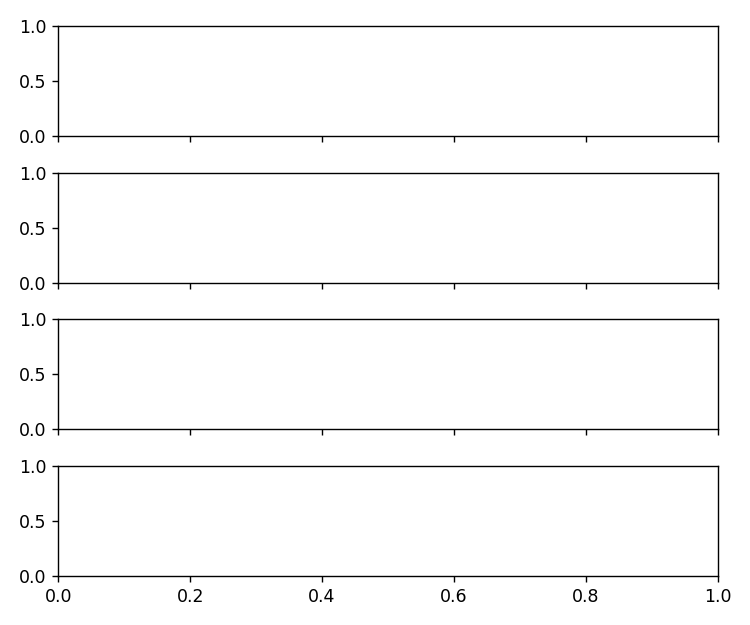

In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt
from scipy.signal import convolve

fig, ax = plt.subplots(4, figsize=(6, 5), sharex=True, tight_layout=True)

def smooth_data(x, window_length=10):
    return convolve(x, np.ones(window_length)/window_length, mode='valid')

def update_plot(step, episode, smooth_window=10, target=195, target_update=500):
    for ax_ in ax:
        ax_.cla()
    episodes = np.arange((episode))
    ax[0].scatter(episodes, diagnostics['rewards'], s=1)      
    if episode > smooth_window:
        ax[0].plot(episodes[:-smooth_window+1], 
                   smooth_data(diagnostics['rewards']), alpha=0.5, lw=2)        
    ax[1].plot(episodes, diagnostics['loss'])
    ax[2].plot(episodes, np.array(diagnostics['q_sum'])/(np.array(diagnostics['q_N'])+1e-4))
                   
    #ax[0].plot(episodes, [target]*len(episodes), 'k--')
    ax[0].set_ylabel('Recompensa');
    ax[1].set_ylabel('Loss')
    ax[2].set_ylabel('Q promedio')
    ax[3].plot(episodes, epsilon(episodes))
    ax[3].set_ylabel('Epsilon')
    ax[3].set_xlabel('Episodios')
    ax[0].set_title("Paso %d" % (step))
    fig.canvas.draw()

In [ ]:
import numpy as np
import gym
from tqdm.notebook import tqdm

torch.manual_seed(123)

env = wrap_env(gym.make(env_name))
n_state = (4, 84, 84)
n_action = env.action_space.n 

dqn_model = DeepQNetwork(q_model=ConvolutionalNeuralNetwork(n_state[0], n_action),
                         gamma = 0.99,
                         double_dqn=True,
                         target_update_freq=1000,
                         learning_rate=1e-4, huber=True)

def epsilon(episode, epsilon_init=0.1, epsilon_end=0.01, epsilon_rate=1e-2):
    return epsilon_end + (epsilon_init - epsilon_end) * np.exp(-epsilon_rate*episode) 

memory = ReplayMemory(n_state, memory_length=100000)        

diagnostics = {'rewards': [0], 'loss': [0],
               'q_sum': [0], 'q_N': [0]}

episode = 1
end = False
stacked_states = env.reset()

for step in tqdm(range(1000000)):    
    # Escoger acción
    state = preprocess(stacked_states)
    a, q = dqn_model.select_action(state.unsqueeze(0), epsilon(episode))
    if q is not None:
        diagnostics['q_sum'][-1] += q
        diagnostics['q_N'][-1] += 1
    
    # Aplicar la acción 
    stacked_states_next, r, end, info = env.step(a)  
    diagnostics['rewards'][-1] += r
    # Guardar en memoria
    memory.push(state, preprocess(stacked_states_next), 
                a, torch.tensor(r), end)
    
    stacked_states = stacked_states_next
    
    # Actualizar modelo    
    mini_batch = memory.sample(32)
    if not mini_batch is None:
        diagnostics['loss'][-1] += dqn_model.update(mini_batch)            
    
    # Preparar siguiente episodio
    if end:
        if episode % 5 == 0:
            update_plot(step, episode)
        episode += 1   
        end = False
        stacked_states = env.reset()
        diagnostics['rewards'].append(0)
        diagnostics['loss'].append(0)
        diagnostics['q_sum'].append(0)
        diagnostics['q_N'].append(0)

In [ ]:
import pickle

with open("model_freq_1000_200k.pkl", "wb") as f:
    pickle.dump([dqn_model, dqn_model.q_policy.state_dict()], f)

In [19]:
import pickle
with open("model_freq_1000_noneg_200k.pkl", "rb") as f:
    dqn_model_loaded, q_policy_state_dict_loaded = pickle.load(f)

In [22]:
import gym
from time import sleep

env = wrap_env(gym.make(env_name), skip=1)
stacked_states = env.reset()
end = False

while not end:
    state = preprocess(stacked_states)
    a, q = dqn_model_loaded.select_action(state.unsqueeze(0))
    #stacked_states = []
    #for k in range(4):
    #    s, r, end, info = env.step(a)  
    #    stacked_states.append(s)
    stacked_states, r, end, info = env.step(a)
    #for k in range(stacked_states.count()):
    env.render() 
        #stacked_states = stacked_states[1:]
    #stacked_states.append(s)
    
    sleep(.01)     

In [23]:
env.close()

In [ ]:
import gym
from time import sleep
from IPython import display

env = gym.make("SpaceInvaders-v0") 
env.reset()
end = False

fig, ax = plt.subplots(figsize=(7, 4))
img = plt.imshow(env.render(mode='rgb_array'))

stacked_states = []
stacked_states.append(env.reset())
for k in range(3):
    s, r, end, info = env.step(0)  
    stacked_states.append(s)

while not end:
    
    state = preprocess(stacked_states)
    a, q = dqn_model.select_action(state.unsqueeze(0))
    s, r, end, info = env.step(a)
    stacked_states = stacked_states[1:]
    stacked_states.append(s)
    
    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    
    #sleep(.02)     